single leptonJet mass spectrum seems to have two peaks - one around J/Psi (3.1GeV), other around Z (91GeV).
Do a fit to see how close they are.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
import json
datasets_=json.load(open('../Samples/control_data2018.json'))
datasets = dict(
    A={'files': datasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'},
    B={'files': datasets_['B'], 'treename': 'ffNtuples/ffNtuple'},
    C={'files': datasets_['C'], 'treename': 'ffNtuples/ffNtuple'},
    D={'files': datasets_['D'], 'treename': 'ffNtuples/ffNtuple'},
)

In [3]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        masslow_axis = hist.Bin("mass", "mass [GeV]", 50, 0, 10)
        masshigh_axis = hist.Bin("mass", "mass [GeV]", 50, 70, 110)
        
        self._accumulator = processor.dict_accumulator({
            'mass_l': hist.Hist("#counts/0.2GeV", dataset_axis, masslow_axis),
            "mass_h": hist.Hist("#counts/0.8GeV", dataset_axis, masshigh_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        ## data sample already in control region
        output['mass_l'].fill(dataset=dataset, mass=leptonjets.mass.flatten())
        output['mass_h'].fill(dataset=dataset, mass=leptonjets.mass.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [8]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2545/2545 [01:45<00:00, 24.15items/s]


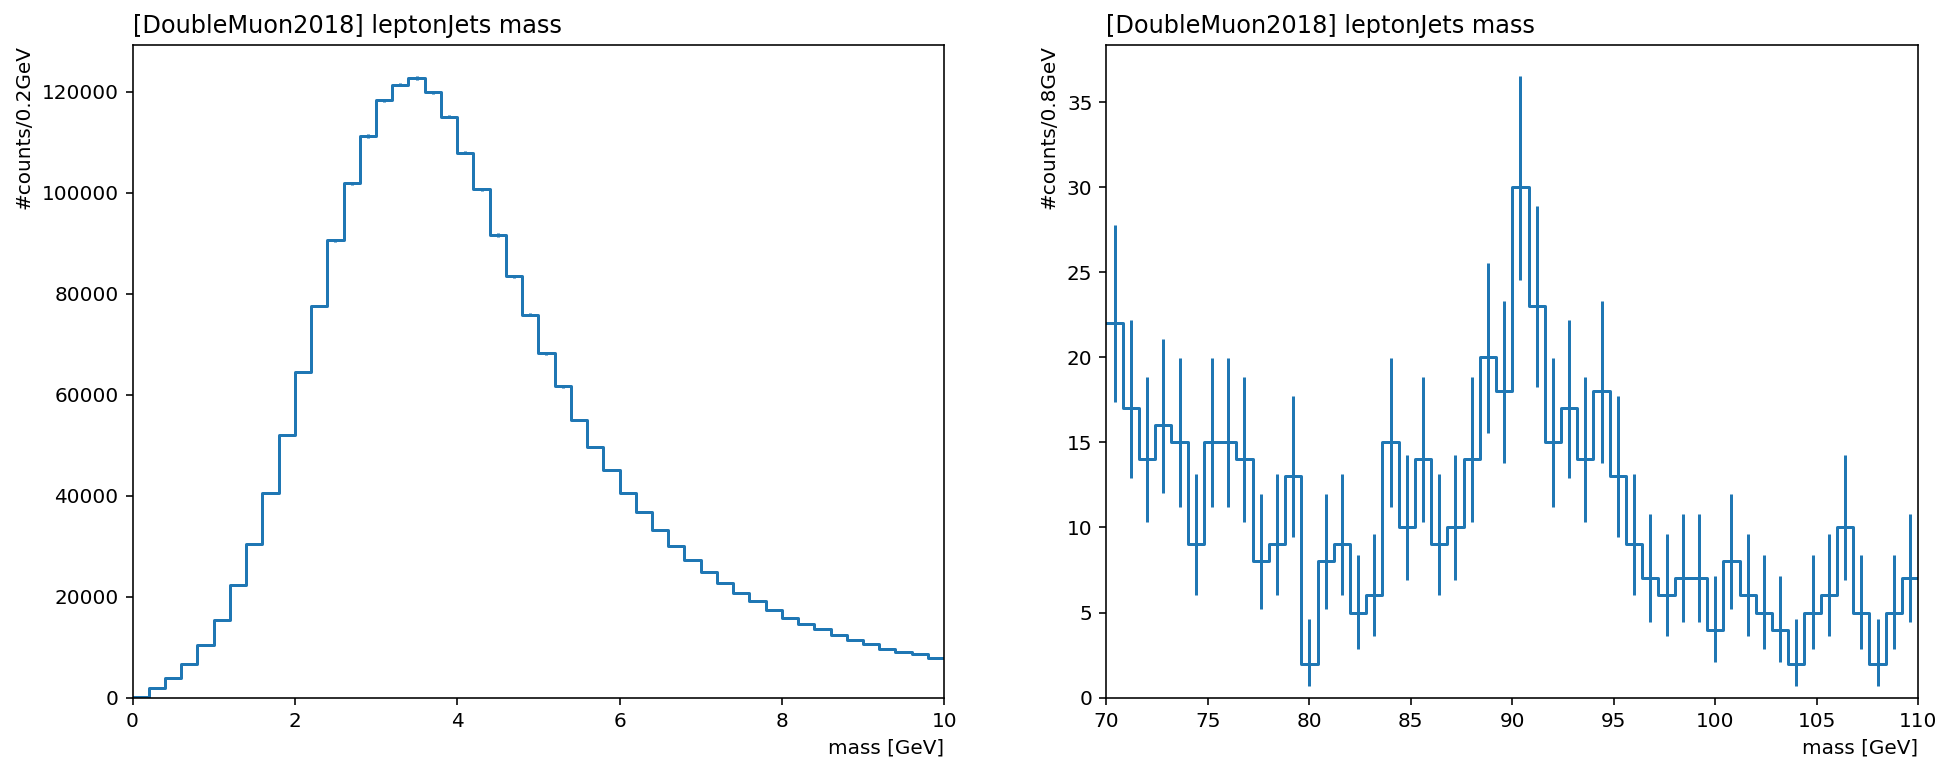

In [9]:
fig, axes = plt.subplots(1,2, figsize=(16, 6))
hist.plot1d(output['mass_l'].project('dataset'), ax=axes[0])
hist.plot1d(output['mass_h'].project('dataset'), ax=axes[1])

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets mass', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

Dump these histograms into ROOT file..

In [10]:
import uproot
outputfile = uproot.create("leptonjetmass.root")
outputfile['mass_low'] = hist.export1d(output['mass_l'].project('dataset'))
outputfile['mass_high'] = hist.export1d(output['mass_h'].project('dataset'))
outputfile.close()